Import data from previous notebook and librairies

In [24]:
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from scipy.stats import uniform
from tqdm import tqdm
import time

pd.options.display.float_format = '{:.6f}'.format
data = pd.read_csv('X_clean.csv')

data.head()


,TotalGHGEmissions,SiteEnergyUse(kBtu),NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),Age,EnergyPerBuilding,Latitude,Longitude,RatioElectricityUse,...,Primary_Residence Hall,Primary_Restaurant,Primary_Retail Store,Primary_Self-Storage Facility,Primary_Senior Care Community,Primary_Small- and Mid-Sized Office,Primary_Supermarket / Grocery Store,Primary_University,Primary_Warehouse,Primary_Worship Facility
0,249.980000,7226362.500000,1.000000,12,88434,97,7226362.500000,47.612200,-122.337990,0.160041,...,False,False,False,False,False,False,False,False,False,False
1,295.860000,8387933.000000,1.000000,11,88502,28,8387933.000000,47.613170,-122.333930,0.113309,...,False,False,False,False,False,False,False,False,False,False
2,2089.280000,72587024.000000,1.000000,41,759392,55,72587024.000000,47.613930,-122.338100,0.199973,...,False,False,False,False,False,False,False,False,False,False
3,286.430000,6794584.000000,1.000000,10,61320,98,6794584.000000,47.614120,-122.336640,0.119437,...,False,False,False,False,False,False,False,False,False,False
4,505.010000,14172606.000000,1.000000,18,113580,44,14172606.000000,47.613750,-122.340470,0.111020,...,False,False,False,False,False,False,False,False,False,False


Creation of class Data, where it setup all model, and have a public method run to benchmark differents model with the datasett using Kfold to try different setup of tain/test data.
All model use CV to setup best hyperparameters.

In [25]:
class Data:
    def __init__(self, data, y_n):
        self.epoch = 5
        self.layout = {
            'linear R2': [],
            'ridge R2': [],
            'lasso R2': [],
            'elastic R2': [],
            'random forest R2': [],
            'xgboost R2': [],
            'linear MAE': [],
            'ridge MAE': [],
            'lasso MAE': [],
            'elastic MAE': [],
            'random forest MAE': [],
            'xgboost MAE': [],
            'linear RMSE': [],
            'ridge RMSE': [],
            'lasso RMSE': [],
            'elastic RMSE': [],
            'random forest RMSE': [],
            'xgboost RMSE': [],
            'ridge alpha': [],
            'lasso alpha': [],
            'elastic alpha': [],
            'elastic l1_ratio': [],
            'random forest params': [],
            'xgboost params': [],
            'linear time': [],
            'ridge time': [],
            'lasso time': [],
            'elastic time': [],
            'random forest time': [],
            'xgboost time': []
        }
        self.iter = 0
        self.origin = data.copy()
        self.y_n = y_n
        self.data = data
        self.preprocess()
        self.y = self.data.iloc[:, y_n]
        self.data = self.data.iloc[:, 2:]
        print(f"Prediction {self.y.name}")
        
    def preprocess(self):
        scaler = StandardScaler()
        self.data = pd.DataFrame(scaler.fit_transform(self.data), columns=self.data.columns)
           
    def run(self):
        kf = KFold(n_splits=self.epoch, shuffle=True, random_state=42)
        models = [
            LinearRegression(),
            Ridge(),
            Lasso(),
            ElasticNet(),
            RandomForestRegressor(),
            xgb.XGBRegressor()
        ]
        total_steps_per_epoch = 6
        with tqdm(total=kf.get_n_splits() * total_steps_per_epoch, desc="Epoch Progress") as pbar:
            for train_index, test_index in kf.split(self.data):
                self.X_train, self.X_test = self.data.iloc[train_index], self.data.iloc[test_index]
                self.y_train, self.y_test = self.y.iloc[train_index], self.y.iloc[test_index]
                models[0] = self.linear_regression(models[0])
                pbar.update(1)
                models[1] = self.ridge_regression(models[1])
                pbar.update(1)
                models[2] = self.lasso_regression(models[2])
                pbar.update(1)
                models[3] = self.elastic_net(models[3])
                pbar.update(1)
                models[4] = self.random_forest_regression(models[4])
                pbar.update(1)
                models[5] = self.xgboost_regression(models[5])
                pbar.update(1)       
        return self.layout

    def linear_regression(self, model):
        start_time = time.time()
        model.fit(self.X_train, self.y_train)
        pred = model.predict(self.X_test)
        end_time = time.time()
        self.layout['linear R2'].append(r2_score(self.y_test, pred))
        self.layout['linear MAE'].append(mean_absolute_error(self.y_test, pred))
        self.layout['linear RMSE'].append(mean_squared_error(self.y_test, pred))
        self.layout['linear time'].append(end_time - start_time)
        return model

    def ridge_regression(self, model):
        start_time = time.time()
        param_distributions_ridge = {'alpha': uniform(0.01, 1000)}
        random_search_ridge = RandomizedSearchCV(model, param_distributions_ridge, n_iter=20, cv=5, scoring='r2', n_jobs=-1)
        random_search_ridge.fit(self.X_train, self.y_train)
        best_ridge = random_search_ridge.best_estimator_
        pred = best_ridge.predict(self.X_test)
        end_time = time.time()
        self.layout['ridge R2'].append(r2_score(self.y_test, pred))
        self.layout['ridge MAE'].append(mean_absolute_error(self.y_test, pred))
        self.layout['ridge RMSE'].append(mean_squared_error(self.y_test, pred))
        self.layout['ridge alpha'].append(random_search_ridge.best_params_['alpha'])
        self.layout['ridge time'].append(end_time - start_time)
        return best_ridge

    def lasso_regression(self, model):
        start_time = time.time()
        param_distributions_lasso = {'alpha': uniform(0.01, 1000)}
        random_search_lasso = RandomizedSearchCV(model, param_distributions_lasso, n_iter=20, cv=5, scoring='r2', n_jobs=-1)
        random_search_lasso.fit(self.X_train, self.y_train)
        best_lasso = random_search_lasso.best_estimator_
        pred = best_lasso.predict(self.X_test)
        end_time = time.time()
        self.layout['lasso R2'].append(r2_score(self.y_test, pred))
        self.layout['lasso MAE'].append(mean_absolute_error(self.y_test, pred))
        self.layout['lasso RMSE'].append(mean_squared_error(self.y_test, pred))
        self.layout['lasso alpha'].append(random_search_lasso.best_params_['alpha'])
        self.layout['lasso time'].append(end_time - start_time)
        return best_lasso

    def elastic_net(self, model):
        start_time = time.time()
        param_distributions_elastic_net = {
            'alpha': uniform(0.01, 1000),
            'l1_ratio': uniform(0, 1)
        }
        random_search_elastic_net = RandomizedSearchCV(model, param_distributions_elastic_net, n_iter=20, cv=5, scoring='r2', n_jobs=-1)
        random_search_elastic_net.fit(self.X_train, self.y_train)
        best_elastic_net = random_search_elastic_net.best_estimator_
        pred = best_elastic_net.predict(self.X_test)
        end_time = time.time()
        self.layout['elastic R2'].append(r2_score(self.y_test, pred))
        self.layout['elastic MAE'].append(mean_absolute_error(self.y_test, pred))
        self.layout['elastic RMSE'].append(mean_squared_error(self.y_test, pred))
        self.layout['elastic alpha'].append(random_search_elastic_net.best_params_['alpha'])
        self.layout['elastic l1_ratio'].append(random_search_elastic_net.best_params_['l1_ratio'])
        self.layout['elastic time'].append(end_time - start_time)
        return best_elastic_net

    def random_forest_regression(self, model):
        start_time = time.time()
        param_grid_rf = {
            'n_estimators': [50, 100],
            'max_depth': [10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
        random_search_rf = GridSearchCV(model, param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
        random_search_rf.fit(self.X_train, self.y_train)
        best_rf = random_search_rf.best_estimator_
        pred = best_rf.predict(self.X_test)
        end_time = time.time()
        self.layout['random forest R2'].append(r2_score(self.y_test, pred))
        self.layout['random forest MAE'].append(mean_absolute_error(self.y_test, pred))
        self.layout['random forest RMSE'].append(mean_squared_error(self.y_test, pred))
        self.layout['random forest params'].append(random_search_rf.best_params_)
        self.layout['random forest time'].append(end_time - start_time)
        return best_rf

    def xgboost_regression(self, model):
        start_time = time.time()
        param_distributions_xgb = {
            'n_estimators': [10, 50, 100],
            'max_depth': [3, 6, 10],
            'learning_rate': uniform(0.01, 0.3),
            'alpha': uniform(0, 1)
        }
        random_search_xgb = RandomizedSearchCV(model, param_distributions_xgb, n_iter=20, cv=5, scoring='r2', n_jobs=-1)
        random_search_xgb.fit(self.X_train, self.y_train)
        best_xgb = random_search_xgb.best_estimator_
        pred = best_xgb.predict(self.X_test)
        end_time = time.time()
        self.layout['xgboost R2'].append(r2_score(self.y_test, pred))
        self.layout['xgboost MAE'].append(mean_absolute_error(self.y_test, pred))
        self.layout['xgboost RMSE'].append(mean_squared_error(self.y_test, pred))
        self.layout['xgboost params'].append(random_search_xgb.best_params_)
        self.layout['xgboost time'].append(end_time - start_time)
        return best_xgb

Transorme the result from the class method run to dataframe to use it later and run the test

In [26]:
df = Data(data, 0)

res = pd.DataFrame(df.run())
res.head()

Prediction TotalGHGEmissions


Epoch Progress:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch Progress: 100%|██████████| 30/30 [00:55<00:00,  1.85s/it]


,linear R2,ridge R2,lasso R2,elastic R2,random forest R2,xgboost R2,linear MAE,ridge MAE,lasso MAE,elastic MAE,...,elastic alpha,elastic l1_ratio,random forest params,xgboost params,linear time,ridge time,lasso time,elastic time,random forest time,xgboost time
0,-320424924260759618661122048.000000,0.630344,-0.000769,-0.000769,0.780509,0.634560,1373298489367.847168,0.196545,0.415828,0.415828,...,180.004496,0.079542,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...","{'alpha': 0.5736776636119822, 'learning_rate':...",0.013029,3.989112,0.376981,0.289513,5.991748,4.155179
1,-2502374187035890524677472256.000000,0.687688,-0.001216,-0.001216,0.963619,0.716749,5424964265154.599609,0.186974,0.450305,0.450305,...,366.940206,0.590673,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...","{'alpha': 0.4164627512151603, 'learning_rate':...",0.013031,0.332832,0.298270,0.282322,6.471929,3.492486
2,-318362678869128107786240.000000,0.745446,-0.000237,-0.000237,0.740375,0.759315,49419501877.390999,0.204288,0.479800,0.479800,...,136.572657,0.338730,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...","{'alpha': 0.09550511832668918, 'learning_rate'...",0.012016,0.320271,0.290928,0.294410,7.006223,3.015291
3,-22867597634571696152147656704.000000,0.803594,-0.000066,0.032412,0.828249,0.810867,26160528131986.476562,0.180820,0.453240,0.440856,...,4.041558,0.151243,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_...","{'alpha': 0.8953920616646346, 'learning_rate':...",0.012536,0.322003,0.300807,0.284367,5.595033,2.651402
4,-809396564112432921837568.000000,0.710815,-0.000269,0.017275,0.653572,0.752216,108057735285.143433,0.204797,0.495610,0.487982,...,47.394873,0.004699,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...","{'alpha': 0.8271178310040358, 'learning_rate':...",0.013103,0.321735,0.289702,0.290011,6.356564,2.317350


Calculation of means to compare all model and visualisation - R2

              index         0
0         linear R2 -1.000000
1          ridge R2  0.715577
2          lasso R2 -0.000511
3        elastic R2  0.009493
4  random forest R2  0.793265
5        xgboost R2  0.734741


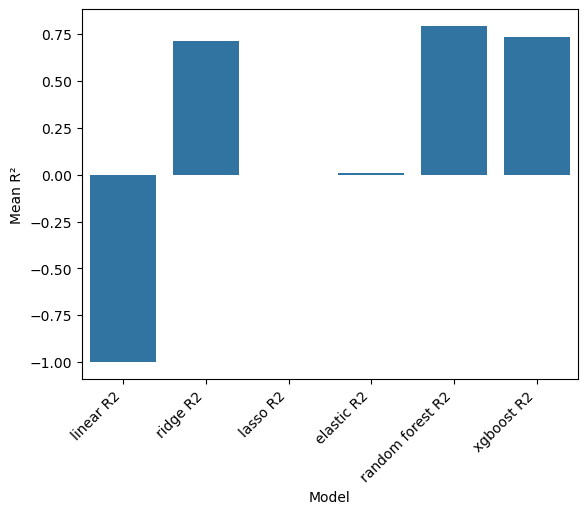

In [29]:
list_r2  = ['linear R2', 'ridge R2', 'lasso R2', 'elastic R2','random forest R2','xgboost R2']
res[list_r2] = res[list_r2].clip(lower=-1, upper=1)

scores_r2 = res[list_r2].mean().reset_index()
print(scores_r2)
scores_r2.columns = ['Model', 'Mean R²']
sns.barplot(x='Model', y='Mean R²', data=scores_r2)
plt.xticks(rotation=45, ha='right')
plt.show()

Random forest have the best score but xgboost and ridge are close

               index        0
0         linear MAE 1.000000
1          ridge MAE 0.194685
2          lasso MAE 0.458957
3        elastic MAE 0.454954
4  random forest MAE 0.081722
5        xgboost MAE 0.097833


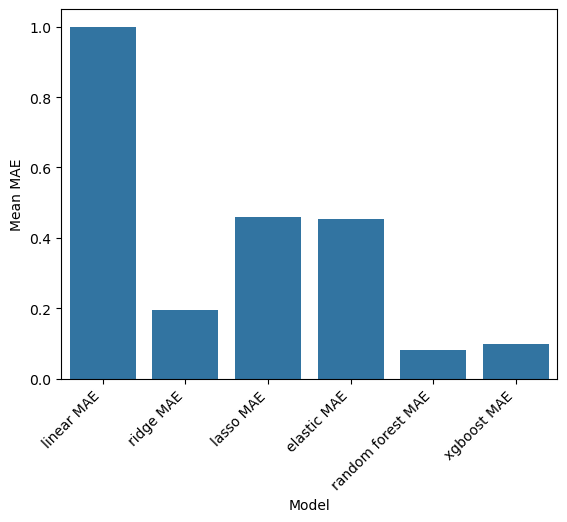

In [30]:
list_r2  = ['linear MAE', 'ridge MAE', 'lasso MAE', 'elastic MAE','random forest MAE','xgboost MAE']
res[list_r2] = res[list_r2].clip(lower=-1, upper=1)

scores_r2 = res[list_r2].mean().reset_index()
print(scores_r2)
scores_r2.columns = ['Model', 'Mean MAE']
sns.barplot(x='Model', y='Mean MAE', data=scores_r2)
plt.xticks(rotation=45, ha='right')
plt.show()

                index        0
0         linear RMSE 1.000000
1          ridge RMSE 0.271999
2          lasso RMSE 0.816878
3        elastic RMSE 0.815437
4  random forest RMSE 0.239007
5        xgboost RMSE 0.249223


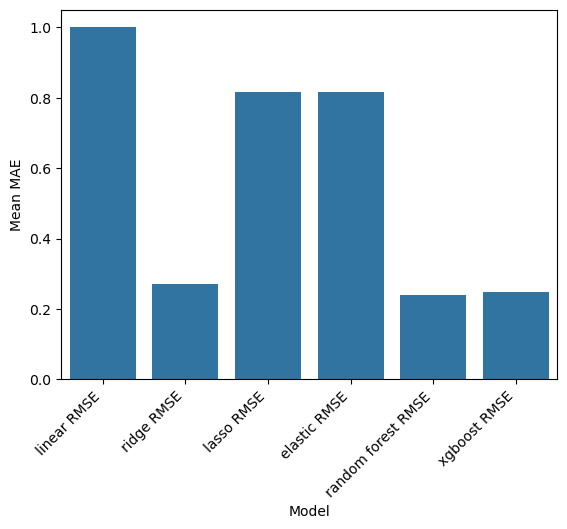

In [31]:
list_r2  = ['linear RMSE', 'ridge RMSE', 'lasso RMSE', 'elastic RMSE','random forest RMSE','xgboost RMSE']
res[list_r2] = res[list_r2].clip(lower=-1, upper=1)

scores_r2 = res[list_r2].mean().reset_index()
print(scores_r2)
scores_r2.columns = ['Model', 'Mean RMSE']
sns.barplot(x='Model', y='Mean RMSE', data=scores_r2)
plt.xticks(rotation=45, ha='right')
plt.show()

Calculation of means to compare all model and visualisation - time

                index        0
0         linear time 0.012743
1          ridge time 1.057190
2          lasso time 0.311338
3        elastic time 0.288124
4  random forest time 6.284300
5        xgboost time 3.126341


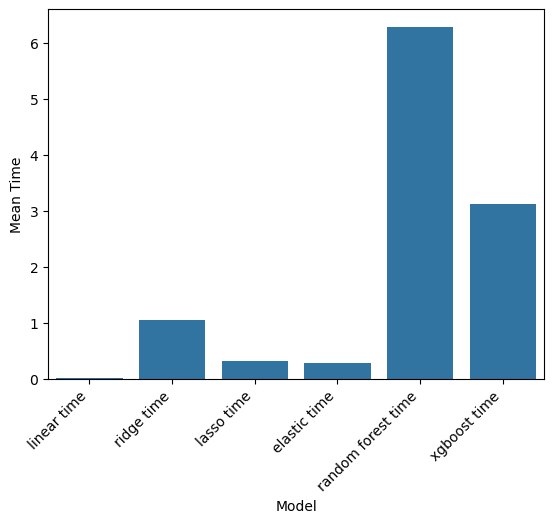

In [28]:
time = res[['linear time',	'ridge time',	'lasso time',	'elastic time',	'random forest time',	'xgboost time']].mean().reset_index()
print(time)
time.columns = ['Model', 'Mean Time']
sns.barplot(x='Model', y='Mean Time', data=time)
plt.xticks(rotation=45, ha='right')
plt.show()

the ones with the best time have very bad R2 score, so we keep only these 3 : ridge, random forest, xgboost
- ridge R2 : 0.718525 time : 0.320593
- random forest R2 : 0.797943 time : 5.723359
- xgboost R2 : 0.747938 time : 2.973722


- If we want to have the best model we choose random forest
- If we want to have the most efficient we choose ridge
- If we want middle in both we choose xgboost 